# Angle Tracking

This notebook processes video data to track the rotation of an object, calculate its angular velocity, and analyze the results. The code is split into sections for modular execution.

In [12]:
# Import necessary libraries
import cv2
import numpy as np
import math
import time
import matplotlib.pyplot as plt
from config import *
from utils import *
import os

## Initialization and Setup

This section initializes global variables, sets up video capture, and prepares for processing.

In [13]:
# Global variables
prev_angle = None
cumulative_angle = 0.0
rotation_count = 0
frame_count = 0
delta_angles = []
angle_list = []
pixel_count_list = []
rotation_pos_list = []


# Initialize video capture
filename = os.path.splitext(os.path.basename(video_path))[0]
output_path = f"output/{filename}_output.mov"
cap = cv2.VideoCapture(video_path)

if display_video:
    fourcc = cv2.VideoWriter_fourcc(*'XVID')
    out = cv2.VideoWriter(output_path, fourcc, 20.0, 
                     (crop_x_max - crop_x_min, crop_y_max - crop_y_min))

## Frame Processing and Angle Calculation

This section processes each frame of the video, detects the object, calculates its angle, and tracks rotations.

In [14]:
cropped_frame = None
mask = None
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    cropped_frame = crop_circle(frame)
    frame_count += 1

    mask = detect_orange_object(cropped_frame)
    centroid = find_centroid(mask)

    if centroid:
        cx, cy = centroid
        dx = cx - center[0]
        dy = center[1] - cy  # Flip Y-axis for proper angle calculation
        current_angle = math.atan2(dy, dx)

        cv2.line(cropped_frame, center, (cx, cy), (255, 0, 0), 2)
        cv2.circle(cropped_frame, (cx, cy), 5, (0, 255, 0), -1)

        if prev_angle is not None:
            # Calculate angle delta and adjust for wrapping
            delta = current_angle - prev_angle
            if delta > math.pi:
                delta -= 2 * math.pi
            elif delta < -math.pi:
                delta += 2 * math.pi

            cumulative_angle += delta
            angle_list.append(cumulative_angle)
            delta_angles.append(delta)
            pixel_count_list.append(cv2.countNonZero(mask))

            # Check for full rotations
            if abs(cumulative_angle) >= 2 * math.pi:
                rotation_pos_list.append((cx, cy))
                rotation_count += 1
                cumulative_angle = math.copysign(
                    abs(cumulative_angle) % (2 * math.pi), 
                    cumulative_angle
                )

        prev_angle = current_angle

    if display_video:
        # Draw rotation info
        cv2.circle(cropped_frame, center, 5, (0, 0, 255), -1)
        cv2.putText(cropped_frame, f"Rotations: {rotation_count}", (10, 30),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
        cv2.putText(cropped_frame, f"Current Angle: {math.degrees(current_angle):.2f} degrees",
                    (10, 60), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)

        # Write and display frame
        out.write(cropped_frame)
        cv2.imshow('Rotation Counter', cropped_frame)

        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

cap.release()
cv2.destroyAllWindows()

## Post-Processing and Calculations

This section calculates the total rotations, RPM, and performs statistical analysis on the angle deltas.

In [15]:
# Calculate RPM
total_angle = sum(delta_angles)     # Angle in radians
total_rotation = total_angle / (2 * math.pi)

total_time = frame_count / fps  # Time in seconds
total_min = total_time / 60
rpm = total_rotation / total_min

print(f"Total rotations: {total_rotation}")
print(f"Estimated RPM: {rpm}")

# Perform analysis on delta_angles
mean_delta = np.mean(delta_angles)
std_dev_delta = np.std(delta_angles)
max_delta = np.max(delta_angles)
min_delta = np.min(delta_angles)

mean_delta_rev = mean_delta / (math.pi * 2)
std_dev_delta_rev = std_dev_delta / (math.pi * 2)

Total rotations: -49.700651124946226
Estimated RPM: -57.587841473968574


## Visualization of Results

This section visualizes the results using a histogram of the angle deltas.

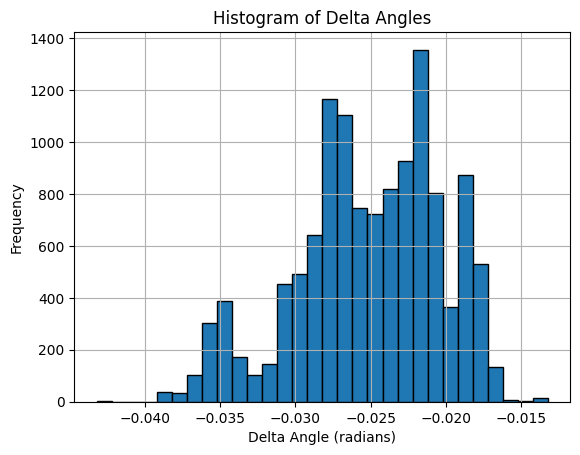

Mean of delta angles: -0.0251 radians, -0.0040 revs
Standard deviation of delta angles: 0.0048 radians, 0.0008 revs
Max delta angle: -0.0132 radians
Min delta angle: -0.0432 radians
Total frames: 12434


In [16]:
# Plot histogram of delta angles
plt.hist(delta_angles, bins=30, edgecolor='black')
plt.title('Histogram of Delta Angles')
plt.xlabel('Delta Angle (radians)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

print(f"Mean of delta angles: {mean_delta:.4f} radians, {mean_delta_rev:.4f} revs")
print(f"Standard deviation of delta angles: {std_dev_delta:.4f} radians, {std_dev_delta_rev:.4f} revs")
print(f"Max delta angle: {max_delta:.4f} radians")
print(f"Min delta angle: {min_delta:.4f} radians")
print(f"Total frames: {frame_count}")

# Data Analysis Plan

## Centroid Movement Over Rotations
I will track centroid positions after each full rotation to visualize movement patterns and detect potential drift. This will help identify inconsistencies in rotation and sources of error.

## Delta Angle vs. Pixel Count
I will analyze the relationship between delta angle (Δ angle) and the detected mask's pixel count. By plotting these values, I aim to detect patterns related to perspective distortion or occlusion. This could show a relationship between a change in angle and the pixel count of the mask which could indicate a masking inconsistency that causes a different delta angle calculation.

## Angular Position vs. Pixel Count
This could highlight any correlation from the position of the tracked object and the mask size. This could be caused by distortion, shadows, or poor masking.

## Delta Angle vs. Angular Position
By comparing the commanded delta angle to the actual observed delta angle per frame, I will evaluate rotation accuracy and identify any systematic biases. Key statistics such as mean, standard deviation, and range of delta angles will be computed.

## Statistical Analysis & RPM Estimation
I will calculate:
- Mean, standard deviation, max, and min of delta angles
- Mean delta angle converted into revolutions
- RPM estimation based on total rotations and elapsed time

These analyses will provide insights into rotational behavior and potential improvements for accurate motion tracking.



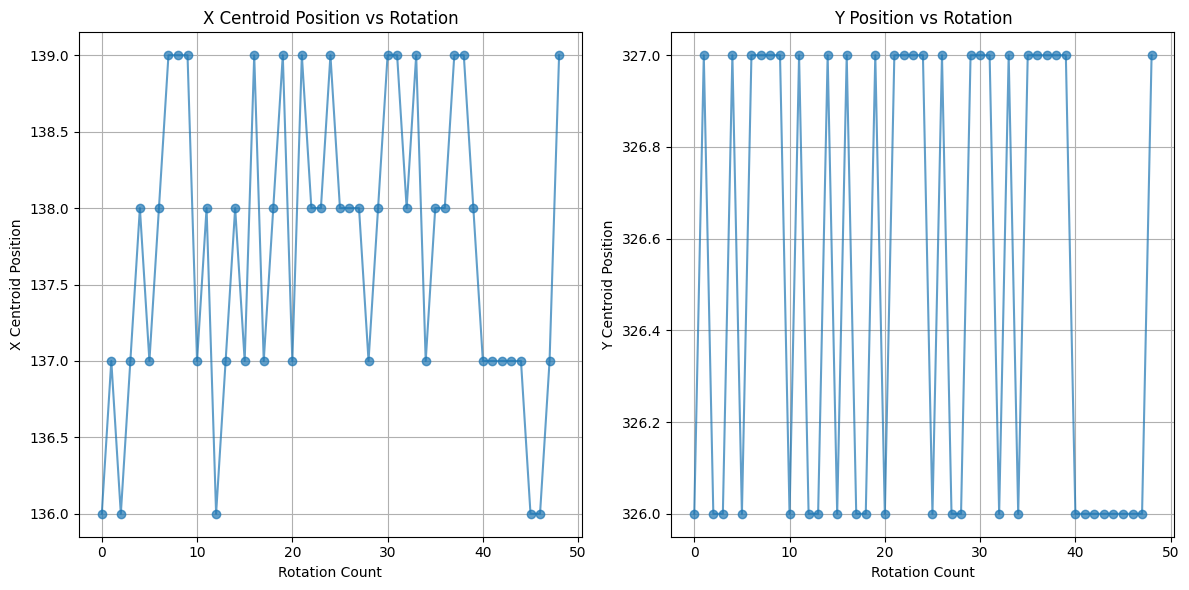

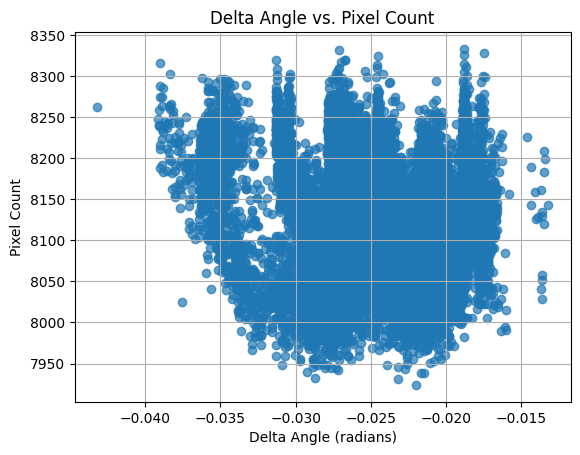

/tmp/ipykernel_110844/2296177910.py:50: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


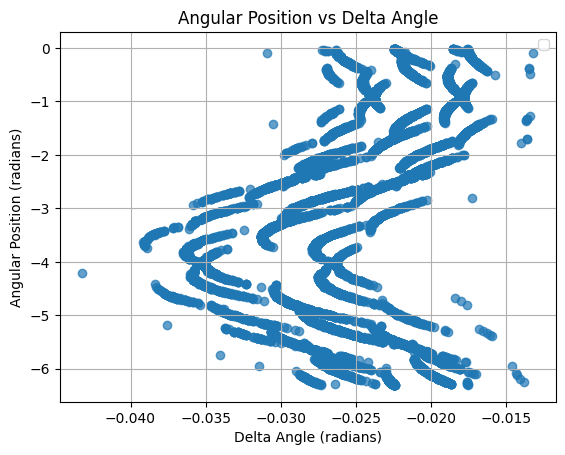

/tmp/ipykernel_110844/2296177910.py:60: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


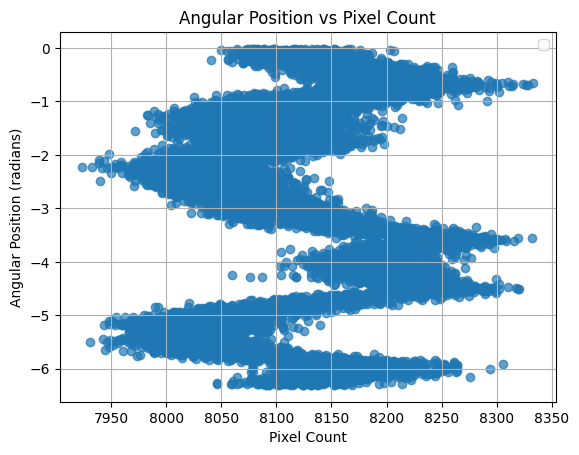

In [18]:
import matplotlib.pyplot as plt
import numpy as np

# # Sample data lists (replace with actual data)
# delta_angles = []  # List of delta angles
# angle_list = []  # Cumulative angles
# pixel_count_list = []  # Pixel counts from the mask
# rotation_pos_list = []  # Centroid positions at full rotations (tuples of (x, y))

# 1. Histogram of X and Y Positions
plt.figure(figsize=(12, 6))
x_vals, y_vals = zip(*rotation_pos_list) if rotation_pos_list else ([], [])

# X and Y positions vs Time
x_len = range(len(x_vals))  # Assuming each position corresponds to a time step
y_len = range(len(y_vals))  # Assuming each position corresponds to a time step

plt.subplot(1, 2, 1)
plt.plot(x_len, x_vals, marker='o', linestyle='-', alpha=0.7)
plt.xlabel("Rotation Count")
plt.ylabel("X Centroid Position")
plt.title("X Centroid Position vs Rotation")
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(y_len, y_vals, marker='o', linestyle='-', alpha=0.7)
plt.xlabel("Rotation Count")
plt.ylabel("Y Centroid Position")
plt.title("Y Position vs Rotation")
plt.grid()

plt.tight_layout()
plt.show()

# 2. Delta Angle vs. Pixel Count
plt.figure()
plt.scatter(delta_angles, pixel_count_list, alpha=0.7)
plt.xlabel("Delta Angle (radians)")
plt.ylabel("Pixel Count")
plt.title("Delta Angle vs. Pixel Count")
plt.grid()
plt.show()

# 3. Delta Angle vs. Actual Angle Over Time
plt.figure()
plt.scatter(delta_angles, angle_list, alpha=0.7)
plt.xlabel("Delta Angle (radians)")
plt.ylabel("Angular Position (radians)")
plt.title("Angular Position vs Delta Angle")
plt.legend()
plt.grid()
plt.show()

# 2. Angular Position vs. Pixel Count 
plt.figure()
plt.scatter(pixel_count_list, angle_list, alpha=0.7)
plt.xlabel("Pixel Count")
plt.ylabel("Angular Position (radians)")
plt.title("Angular Position vs Pixel Count")
plt.legend()
plt.grid()
plt.show()
